# Training

In [1]:
import os
import subprocess
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys

In [2]:
# --- GPU Memory Management ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

GPU memory growth enabled.


In [3]:

# --- Converting Video to 1080p Using ffmpeg ---
video_input = "./input.mp4"
video_output = "input_1080p.mp4"

if not os.path.exists(video_input):
    raise FileNotFoundError(f"Input video '{video_input}' not found.")

if not os.path.exists(video_output):
    print("Converting video to 1080p...")
    cmd = [
        "ffmpeg",
        "-i", video_input,
        "-vf", "scale=1920:1080",
        "-y", 
        video_output
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print("Video conversion completed.")
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"FFmpeg conversion failed: {e.stderr.decode()}")
else:
    print("1080p video already exists, skipping conversion.")


1080p video already exists, skipping conversion.


In [4]:

# --- Extract Frames Using OpenCV ---
cap = cv2.VideoCapture(video_output)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)
cap.release()

if not frames:
    raise ValueError("No frames extracted from the video.")

frames = np.array(frames)
print(f"Extracted {frames.shape[0]} frames of size {frames.shape[2]}x{frames.shape[1]}.")

# Limit to 50 frames
if frames.shape[0] > 50:
    frames = frames[:50]
    print("Using only the first 50 frames.")

num_frames, H, W, C = frames.shape
original_H, original_W = H, W  # Store original dimensions
print(f"Final dataset: {num_frames} frames of size {W}x{H}.")

frames = frames.astype(np.float32) / 255.0

# --- Block size and padding ----
block_size = 128

# Pad frames to make dimensions divisible by block_size
pad_H = (block_size - H % block_size) % block_size
pad_W = (block_size - W % block_size) % block_size

if pad_H > 0 or pad_W > 0:
    print(f"Padding frames to make dimensions divisible by {block_size}x{block_size}.")
    frames = np.pad(frames, ((0, 0), (0, pad_H), (0, pad_W), (0, 0)), mode='constant')
    H, W = frames.shape[1], frames.shape[2]
    print(f"New frame dimensions: {W}x{H}.")


Extracted 374 frames of size 1920x1080.
Using only the first 50 frames.
Final dataset: 50 frames of size 1920x1080.
Padding frames to make dimensions divisible by 128x128.
New frame dimensions: 1920x1152.


In [5]:

# --- Extract Non-Overlapping 128x128 Blocks from All Frames ---
def extract_blocks(frame, block_size):
    """Extract non-overlapping blocks from a frame."""
    H, W, _ = frame.shape
    blocks = []
    positions = []
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = frame[i:i+block_size, j:j+block_size]
            blocks.append(block)
            positions.append((i, j))
    return blocks, positions

all_blocks = []
all_positions = []
all_frame_indices = []

for frame_idx, frame in enumerate(frames):
    blocks, positions = extract_blocks(frame, block_size)
    all_blocks.extend(blocks)
    all_positions.extend(positions)
    all_frame_indices.extend([frame_idx] * len(blocks))

all_blocks = np.array(all_blocks)
all_frame_indices = np.array(all_frame_indices)
all_positions = np.array(all_positions)

print(f"Extracted {all_blocks.shape[0]} blocks of shape {all_blocks.shape[1:]} from {len(frames)} frames.")


Extracted 6750 blocks of shape (128, 128, 3) from 50 frames.


building the model

In [6]:

# --- Encoding Frame Index + Block Position ---
def normalize_position(pos, max_dim):
    return pos / max_dim

normalized_positions = np.array([
    [normalize_position(i, H), normalize_position(j, W), frame_idx / len(frames)]
    for (i, j), frame_idx in zip(all_positions, all_frame_indices)
])

# --- Building the Model ---
input_layer = tf.keras.Input(shape=(3,))  

# Positional encoding
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        encoding.append(tf.sin((2.0 ** i) * np.pi * x))
        encoding.append(tf.cos((2.0 ** i) * np.pi * x))
    return tf.concat(encoding, axis=-1)

pe = positional_encoding(input_layer)

# Convolutional decoder 
x = tf.keras.layers.Dense(256, activation='relu')(pe)
x = tf.keras.layers.Reshape((1, 1, 256))(x)
x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)  # 1x1 -> 2x2
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)   # 2x2 -> 4x4
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)   # 4x4 -> 8x8
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(16, 4, strides=2, padding='same', activation='relu')(x)   # 8x8 -> 16x16
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(8, 4, strides=2, padding='same', activation='relu')(x)    # 16x16 -> 32x32
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(4, 4, strides=2, padding='same', activation='relu')(x)    # 32x32 -> 64x64
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)  # 64x64 -> 128x128

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

# Model architecture
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 3)            0           ['input_1[0][0]']                
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 3)           0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 3)           0           ['input_1[0][0]']            

In [7]:
# --- Training the Model ---
history = model.fit(
    normalized_positions,
    all_blocks,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/200
190/190 [==============================] - 9s 19ms/step - loss: 0.2356 - val_loss: 0.2407
Epoch 2/200
190/190 [==============================] - 3s 15ms/step - loss: 0.1904 - val_loss: 0.2184
Epoch 3/200
190/190 [==============================] - 3s 15ms/step - loss: 0.1411 - val_loss: 0.1725
Epoch 4/200
190/190 [==============================] - 3s 15ms/step - loss: 0.1140 - val_loss: 0.1354
Epoch 5/200
190/190 [==============================] - 3s 15ms/step - loss: 0.0990 - val_loss: 0.1289
Epoch 6/200
190/190 [==============================] - 3s 15ms/step - loss: 0.0883 - val_loss: 0.1224
Epoch 7/200
190/190 [==============================] - 3s 15ms/step - loss: 0.0818 - val_loss: 0.1190
Epoch 8/200
190/190 [==============================] - 3s 15ms/step - loss: 0.0775 - val_loss: 0.1175
Epoch 9/200
190/190 [==============================] - 3s 15ms/step - loss: 0.0738 - val_loss: 0.1136
Epoch 10/200
190/190 [==============================] - 3s 15ms/step - loss: 0.072

In [11]:
# --- 8. Save the Model ---
model_save_path = "./saved_128x128_model"
print(f"Saving model to {model_save_path}...")
model.save(model_save_path)
print("Model saved successfully.")

Saving model to ./saved_128x128_model...


INFO:tensorflow:Assets written to: ./saved_128x128_model\assets


INFO:tensorflow:Assets written to: ./saved_128x128_model\assets


Model saved successfully.


## Frame reconstruction

Generating frames 1 to 6...


Reconstructing Frame 6: 100%|██████████| 135/135 [00:00<00:00, 15028.16it/s]


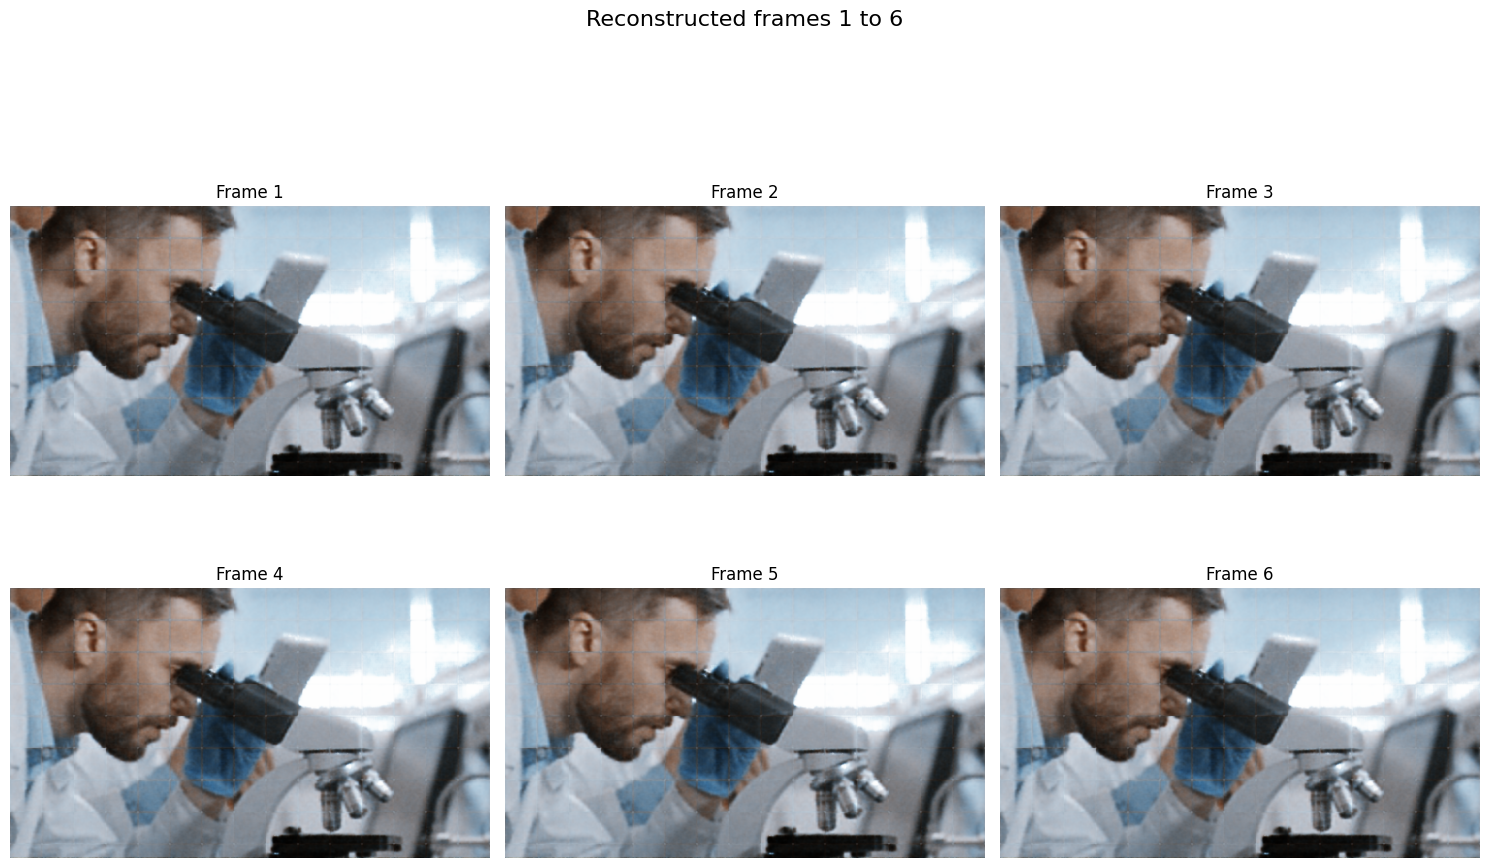

In [10]:
def generate_frame(target_frame_idx):
    total_blocks = (H // block_size) * (W // block_size)
    input_data = np.zeros((total_blocks, 3), dtype=np.float32)
    positions = []
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            norm_i = i / H
            norm_j = j / W
            norm_frame_idx = target_frame_idx / num_frames  # Changed to num_frames
            input_data[idx] = [norm_i, norm_j, norm_frame_idx]
            positions.append((i, j))
            idx += 1
    
    # Batch prediction
    pred_blocks = model.predict(input_data, batch_size=32, verbose=0)
    
    # Reconstruct frame
    reconstructed = np.zeros((H, W, 3), dtype=np.float32)
    with tqdm(total=total_blocks, desc=f"Reconstructing Frame {target_frame_idx}") as pbar:
        for block, (i, j) in zip(pred_blocks, positions):
            reconstructed[i:i+block_size, j:j+block_size] = block
            pbar.update(1)
    
    reconstructed = (reconstructed * 255).astype(np.uint8)
    reconstructed = reconstructed[:original_H, :original_W]
    return reconstructed

# --- Generate Frames 1 to 6 ---
print("Generating frames 1 to 6...")
generated_frames = []
for frame_idx in range(1, 7):  # Frames 1 to 6 inclusive
    frame = generate_frame(frame_idx)
    generated_frames.append(frame)

# --- Display Frames in a 2x3 Grid ---
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
fig.suptitle("Reconstructed frames 1 to 6", fontsize=16)

for idx, (frame, ax) in enumerate(zip(generated_frames, axes.flat)):
    ax.imshow(frame)
    ax.set_title(f"Frame {idx + 1}")
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()

# Inference

Loading model from ./saved_128x128_model...
Model loaded successfully.
Parameters set: 50 frames, padded size 1152x1920, original size 1080x1920
Attempting to get user input...
Non-interactive environment detected, defaulting to frame 0.
Generating frame 0...
Starting generation of Frame 0...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.51 seconds.
Starting frame reconstruction...


Reconstructing Frame 0: 100%|██████████| 135/135 [00:00<00:00, 12274.15it/s]

Reconstruction completed in 0.03 seconds.
Frame 0 generated in 0.54 seconds.
Displaying frame...


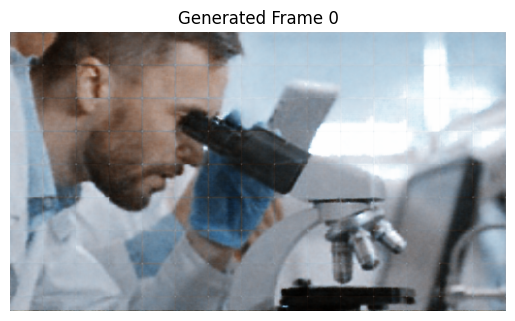

Frame displayed successfully.


In [12]:

# --- Loading saved model ---
model_save_path = "./saved_128x128_model"
print(f"Loading model from {model_save_path}...")
try:
    model = tf.keras.models.load_model(model_save_path)
    print("Model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Failed to load model: {e}")

# --- Parameters ---
block_size = 128
num_frames = 50
H, W = 1152, 1920
original_H, original_W = 1080, 1920
print(f"Parameters set: {num_frames} frames, padded size {H}x{W}, original size {original_H}x{original_W}")

# --- Generate a Frame with Batching ---
def generate_frame(target_frame_idx):
    if not 0 <= target_frame_idx < num_frames:
        raise ValueError(f"Frame index must be between 0 and {num_frames - 1}, got {target_frame_idx}")

    print(f"Starting generation of Frame {target_frame_idx}...")
    start_time = time.time()

    # Precompute inputs
    total_blocks = (H // block_size) * (W // block_size)
    print(f"Preparing {total_blocks} block inputs...")
    input_data = np.zeros((total_blocks, 3), dtype=np.float32)
    positions = []
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            norm_i = i / H
            norm_j = j / W
            norm_frame_idx = target_frame_idx / num_frames
            input_data[idx] = [norm_i, norm_j, norm_frame_idx]
            positions.append((i, j))
            idx += 1
    print("Input preparation completed.")

    # Batch prediction
    print(f"Predicting {total_blocks} blocks...")
    pred_start = time.time()
    try:
        pred_blocks = model.predict(input_data, batch_size=32, verbose=0)
        pred_time = time.time() - pred_start
        print(f"Prediction completed in {pred_time:.2f} seconds.")
    except Exception as e:
        print(f"Prediction failed: {e}")
        raise

    # Reconstruct frame
    print("Starting frame reconstruction...")
    recon_start = time.time()
    reconstructed = np.zeros((H, W, 3), dtype=np.float32)
    with tqdm(total=total_blocks, desc=f"Reconstructing Frame {target_frame_idx}") as pbar:
        for block, (i, j) in zip(pred_blocks, positions):
            reconstructed[i:i+block_size, j:j+block_size] = block
            pbar.update(1)
    
    reconstructed = (reconstructed * 255).astype(np.uint8)
    reconstructed = reconstructed[:original_H, :original_W]
    recon_time = time.time() - recon_start
    print(f"Reconstruction completed in {recon_time:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"Frame {target_frame_idx} generated in {total_time:.2f} seconds.")
    return reconstructed

# --- User Input for Frame Index ---
print("Attempting to get user input...")
try:
    # Check if running interactively
    if sys.stdin.isatty():
        frame_idx = int(input(f"Enter frame index (0 to {num_frames - 1}): "))
    else:
        print("Non-interactive environment detected, defaulting to frame 0.")
        frame_idx = 0
    
    print(f"Generating frame {frame_idx}...")
    generated_frame = generate_frame(frame_idx)
    
    # Display the generated frame
    print("Displaying frame...")
    plt.imshow(generated_frame)
    plt.title(f"Generated Frame {frame_idx}")
    plt.axis('off')
    plt.show()
    print("Frame displayed successfully.")
except ValueError as e:
    print(f"Invalid input: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

# Video reconstruction

In [13]:
# Warming-up model to avoid GPU initialization delay
print("Warming up model with a dummy prediction...")
try:
    model.predict(np.zeros((1, 3)), verbose=0)
    print("Model warm-up completed.")
except Exception as e:
    print(f"Model warm-up failed: {e}")

# --- Parameters ---
block_size = 128
num_frames = 50
H, W = 1152, 1920  # Padded dimensions
original_H, original_W = 1080, 1920  # Original frame size
print(f"Parameters set: {num_frames} frames, padded size {H}x{W}, original size {original_H}x{original_W}")

# --- Generating a Frame with Batching ---
def generate_frame(target_frame_idx):
    print(f"Starting generation of Frame {target_frame_idx}...")
    start_time = time.time()

    # Precompute inputs
    total_blocks = (H // block_size) * (W // block_size)
    print(f"Preparing {total_blocks} block inputs...")
    input_data = np.zeros((total_blocks, 3), dtype=np.float32)
    positions = []
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            norm_i = i / H
            norm_j = j / W
            norm_frame_idx = target_frame_idx / num_frames
            input_data[idx] = [norm_i, norm_j, norm_frame_idx]
            positions.append((i, j))
            idx += 1
    print("Input preparation completed.")

    # Batch prediction
    print(f"Predicting {total_blocks} blocks...")
    pred_start = time.time()
    try:
        pred_blocks = model.predict(input_data, batch_size=32, verbose=0)
        pred_time = time.time() - pred_start
        print(f"Prediction completed in {pred_time:.2f} seconds.")
    except Exception as e:
        print(f"Prediction failed: {e}")
        raise

    # Reconstruct frame
    print("Starting frame reconstruction...")
    recon_start = time.time()
    reconstructed = np.zeros((H, W, 3), dtype=np.float32)
    with tqdm(total=total_blocks, desc=f"Reconstructing Frame {target_frame_idx}") as pbar:
        for block, (i, j) in zip(pred_blocks, positions):
            reconstructed[i:i+block_size, j:j+block_size] = block
            pbar.update(1)
    
    reconstructed = (reconstructed * 255).astype(np.uint8)
    reconstructed = reconstructed[:original_H, :original_W]
    recon_time = time.time() - recon_start
    print(f"Reconstruction completed in {recon_time:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"Frame {target_frame_idx} generated in {total_time:.2f} seconds.")
    return reconstructed

# --- Generating All Frames ---
print(f"Generating {num_frames} frames...")
all_generated_frames = []
for frame_idx in range(num_frames):
    frame = generate_frame(frame_idx)
    all_generated_frames.append(frame)

# --- Creating Video ---
output_video_path = "./output.mp4"
fps = 30  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (original_W, original_H))

print(f"Writing {num_frames} frames to {output_video_path}...")
with tqdm(total=num_frames, desc="Writing Video") as pbar:
    for frame in all_generated_frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(frame_bgr)
        pbar.update(1)

video_writer.release()
print(f"Video saved successfully to {output_video_path}.")

Warming up model with a dummy prediction...
Model warm-up completed.
Parameters set: 50 frames, padded size 1152x1920, original size 1080x1920
Generating 50 frames...
Starting generation of Frame 0...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.22 seconds.
Starting frame reconstruction...


Reconstructing Frame 0: 100%|██████████| 135/135 [00:00<00:00, 15011.03it/s]

Reconstruction completed in 0.03 seconds.
Frame 0 generated in 0.25 seconds.
Starting generation of Frame 1...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.20 seconds.
Starting frame reconstruction...


Reconstructing Frame 1: 100%|██████████| 135/135 [00:00<00:00, 12273.62it/s]


Reconstruction completed in 0.03 seconds.
Frame 1 generated in 0.23 seconds.
Starting generation of Frame 2...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 2: 100%|██████████| 135/135 [00:00<00:00, 14953.15it/s]

Reconstruction completed in 0.03 seconds.
Frame 2 generated in 0.15 seconds.
Starting generation of Frame 3...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.16 seconds.
Starting frame reconstruction...


Reconstructing Frame 3: 100%|██████████| 135/135 [00:00<00:00, 13457.34it/s]

Reconstruction completed in 0.03 seconds.


Frame 3 generated in 0.19 seconds.
Starting generation of Frame 4...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 4: 100%|██████████| 135/135 [00:00<00:00, 13497.44it/s]


Reconstruction completed in 0.03 seconds.
Frame 4 generated in 0.16 seconds.
Starting generation of Frame 5...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 5: 100%|██████████| 135/135 [00:00<00:00, 13508.39it/s]


Reconstruction completed in 0.03 seconds.
Frame 5 generated in 0.16 seconds.
Starting generation of Frame 6...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 6: 100%|██████████| 135/135 [00:00<00:00, 16873.21it/s]


Reconstruction completed in 0.02 seconds.
Frame 6 generated in 0.16 seconds.
Starting generation of Frame 7...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 7: 100%|██████████| 135/135 [00:00<00:00, 14985.21it/s]

Reconstruction completed in 0.02 seconds.
Frame 7 generated in 0.15 seconds.
Starting generation of Frame 8...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 8: 100%|██████████| 135/135 [00:00<00:00, 14989.97it/s]

Reconstruction completed in 0.02 seconds.
Frame 8 generated in 0.15 seconds.
Starting generation of Frame 9...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 9: 100%|██████████| 135/135 [00:00<00:00, 16830.58it/s]

Reconstruction completed in 0.03 seconds.
Frame 9 generated in 0.16 seconds.
Starting generation of Frame 10...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 10: 100%|██████████| 135/135 [00:00<00:00, 15003.47it/s]

Reconstruction completed in 0.03 seconds.
Frame 10 generated in 0.16 seconds.
Starting generation of Frame 11...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 11: 100%|██████████| 135/135 [00:00<00:00, 15903.13it/s]

Reconstruction completed in 0.02 seconds.
Frame 11 generated in 0.15 seconds.
Starting generation of Frame 12...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.15 seconds.
Starting frame reconstruction...


Reconstructing Frame 12: 100%|██████████| 135/135 [00:00<00:00, 12221.69it/s]


Reconstruction completed in 0.03 seconds.
Frame 12 generated in 0.18 seconds.
Starting generation of Frame 13...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 13: 100%|██████████| 135/135 [00:00<00:00, 16859.14it/s]


Reconstruction completed in 0.03 seconds.
Frame 13 generated in 0.15 seconds.
Starting generation of Frame 14...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 14: 100%|██████████| 135/135 [00:00<00:00, 16862.65it/s]

Reconstruction completed in 0.03 seconds.


Frame 14 generated in 0.15 seconds.
Starting generation of Frame 15...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 15: 100%|██████████| 135/135 [00:00<00:00, 17060.80it/s]

Reconstruction completed in 0.02 seconds.


Frame 15 generated in 0.15 seconds.
Starting generation of Frame 16...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 16: 100%|██████████| 135/135 [00:00<00:00, 15745.70it/s]


Reconstruction completed in 0.02 seconds.
Frame 16 generated in 0.15 seconds.
Starting generation of Frame 17...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 17: 100%|██████████| 135/135 [00:00<00:00, 16886.79it/s]


Reconstruction completed in 0.03 seconds.
Frame 17 generated in 0.15 seconds.
Starting generation of Frame 18...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.15 seconds.
Starting frame reconstruction...


Reconstructing Frame 18: 100%|██████████| 135/135 [00:00<00:00, 16828.57it/s]

Reconstruction completed in 0.02 seconds.
Frame 18 generated in 0.17 seconds.
Starting generation of Frame 19...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 19: 100%|██████████| 135/135 [00:00<00:00, 16840.09it/s]


Reconstruction completed in 0.02 seconds.
Frame 19 generated in 0.15 seconds.
Starting generation of Frame 20...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 20: 100%|██████████| 135/135 [00:00<00:00, 15032.95it/s]

Reconstruction completed in 0.02 seconds.
Frame 20 generated in 0.15 seconds.
Starting generation of Frame 21...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.12 seconds.
Starting frame reconstruction...


Reconstructing Frame 21: 100%|██████████| 135/135 [00:00<00:00, 13477.84it/s]

Reconstruction completed in 0.03 seconds.
Frame 21 generated in 0.15 seconds.
Starting generation of Frame 22...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.16 seconds.
Starting frame reconstruction...


Reconstructing Frame 22: 100%|██████████| 135/135 [00:00<00:00, 12273.35it/s]

Reconstruction completed in 0.03 seconds.
Frame 22 generated in 0.20 seconds.
Starting generation of Frame 23...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 23: 100%|██████████| 135/135 [00:00<00:00, 13501.94it/s]


Reconstruction completed in 0.03 seconds.
Frame 23 generated in 0.16 seconds.
Starting generation of Frame 24...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 24: 100%|██████████| 135/135 [00:00<00:00, 14974.11it/s]

Reconstruction completed in 0.03 seconds.


Frame 24 generated in 0.16 seconds.
Starting generation of Frame 25...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 25: 100%|██████████| 135/135 [00:00<00:00, 12275.21it/s]

Reconstruction completed in 0.03 seconds.


Frame 25 generated in 0.16 seconds.
Starting generation of Frame 26...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 26: 100%|██████████| 135/135 [00:00<00:00, 14252.34it/s]


Reconstruction completed in 0.03 seconds.
Frame 26 generated in 0.16 seconds.
Starting generation of Frame 27...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 27: 100%|██████████| 135/135 [00:00<00:00, 14973.72it/s]


Reconstruction completed in 0.03 seconds.
Frame 27 generated in 0.17 seconds.
Starting generation of Frame 28...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.16 seconds.
Starting frame reconstruction...


Reconstructing Frame 28: 100%|██████████| 135/135 [00:00<00:00, 15005.46it/s]

Reconstruction completed in 0.03 seconds.


Frame 28 generated in 0.19 seconds.
Starting generation of Frame 29...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 29: 100%|██████████| 135/135 [00:00<00:00, 13518.71it/s]


Reconstruction completed in 0.04 seconds.
Frame 29 generated in 0.17 seconds.
Starting generation of Frame 30...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 30: 100%|██████████| 135/135 [00:00<00:00, 12255.82it/s]


Reconstruction completed in 0.03 seconds.
Frame 30 generated in 0.16 seconds.
Starting generation of Frame 31...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 31: 100%|██████████| 135/135 [00:00<00:00, 14987.59it/s]

Reconstruction completed in 0.03 seconds.
Frame 31 generated in 0.16 seconds.
Starting generation of Frame 32...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 32: 100%|██████████| 135/135 [00:00<00:00, 13494.22it/s]


Reconstruction completed in 0.03 seconds.
Frame 32 generated in 0.17 seconds.
Starting generation of Frame 33...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 33: 100%|██████████| 135/135 [00:00<00:00, 15000.69it/s]

Reconstruction completed in 0.03 seconds.


Frame 33 generated in 0.18 seconds.
Starting generation of Frame 34...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.15 seconds.
Starting frame reconstruction...


Reconstructing Frame 34: 100%|██████████| 135/135 [00:00<00:00, 12269.89it/s]

Reconstruction completed in 0.03 seconds.
Frame 34 generated in 0.19 seconds.
Starting generation of Frame 35...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 35: 100%|██████████| 135/135 [00:00<00:00, 12262.45it/s]


Reconstruction completed in 0.03 seconds.
Frame 35 generated in 0.17 seconds.
Starting generation of Frame 36...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 36: 100%|██████████| 135/135 [00:00<00:00, 12271.22it/s]


Reconstruction completed in 0.03 seconds.
Frame 36 generated in 0.17 seconds.
Starting generation of Frame 37...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 37: 100%|██████████| 135/135 [00:00<00:00, 12271.22it/s]

Reconstruction completed in 0.03 seconds.
Frame 37 generated in 0.17 seconds.
Starting generation of Frame 38...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 38: 100%|██████████| 135/135 [00:00<00:00, 12808.92it/s]


Reconstruction completed in 0.03 seconds.
Frame 38 generated in 0.17 seconds.
Starting generation of Frame 39...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 39: 100%|██████████| 135/135 [00:00<00:00, 14969.76it/s]


Reconstruction completed in 0.05 seconds.
Frame 39 generated in 0.20 seconds.
Starting generation of Frame 40...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 40: 100%|██████████| 135/135 [00:00<00:00, 14957.50it/s]

Reconstruction completed in 0.03 seconds.
Frame 40 generated in 0.17 seconds.
Starting generation of Frame 41...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 41: 100%|██████████| 135/135 [00:00<00:00, 16876.22it/s]


Reconstruction completed in 0.03 seconds.
Frame 41 generated in 0.16 seconds.
Starting generation of Frame 42...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 42: 100%|██████████| 135/135 [00:00<00:00, 16916.56it/s]


Reconstruction completed in 0.03 seconds.
Frame 42 generated in 0.16 seconds.
Starting generation of Frame 43...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 43: 100%|██████████| 135/135 [00:00<00:00, 16886.29it/s]

Reconstruction completed in 0.03 seconds.


Frame 43 generated in 0.16 seconds.
Starting generation of Frame 44...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 44: 100%|██████████| 135/135 [00:00<00:00, 14999.90it/s]

Reconstruction completed in 0.02 seconds.


Frame 44 generated in 0.16 seconds.
Starting generation of Frame 45...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.17 seconds.
Starting frame reconstruction...


Reconstructing Frame 45: 100%|██████████| 135/135 [00:00<00:00, 14973.32it/s]

Reconstruction completed in 0.03 seconds.
Frame 45 generated in 0.20 seconds.
Starting generation of Frame 46...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.14 seconds.
Starting frame reconstruction...


Reconstructing Frame 46: 100%|██████████| 135/135 [00:00<00:00, 14976.09it/s]


Reconstruction completed in 0.03 seconds.
Frame 46 generated in 0.17 seconds.
Starting generation of Frame 47...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...
Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 47: 100%|██████████| 135/135 [00:00<00:00, 16844.59it/s]

Reconstruction completed in 0.02 seconds.
Frame 47 generated in 0.16 seconds.
Starting generation of Frame 48...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 48: 100%|██████████| 135/135 [00:00<00:00, 16858.64it/s]

Reconstruction completed in 0.02 seconds.
Frame 48 generated in 0.15 seconds.
Starting generation of Frame 49...
Preparing 135 block inputs...
Input preparation completed.
Predicting 135 blocks...


Prediction completed in 0.13 seconds.
Starting frame reconstruction...


Reconstructing Frame 49: 100%|██████████| 135/135 [00:00<00:00, 16883.77it/s]

Reconstruction completed in 0.02 seconds.
Frame 49 generated in 0.15 seconds.


Writing 50 frames to ./output.mp4...


Writing Video: 100%|██████████| 50/50 [00:00<00:00, 71.72it/s]

Video saved successfully to ./output.mp4.
